In [1]:
import quanguru as qg
import numpy as np
import matplotlib.pyplot as plt
import platform

In [2]:
numOfQubits = 2
freequency = 0
freeOperator = qg.Jz
couplingStrength = 1

In [3]:
nQubExchange = numOfQubits * qg.Qubit(frequency=freequency, operator=freeOperator)
nQubHeisenberg = numOfQubits * qg.Qubit(frequency=freequency, operator=freeOperator)

In [4]:
exchangeQubs = list(nQubExchange.subSys.values())
for ind in range(numOfQubits-1):
    es = [exchangeQubs[ind], exchangeQubs[ind+1]]
    nQubExchange.createTerm(operator=[qg.sigmax, qg.sigmax], frequency=0, qSystem=es)
    nQubExchange.createTerm(operator=[qg.sigmay, qg.sigmay], frequency=0, qSystem=es)

In [5]:
HeisenbergQubs = list(nQubHeisenberg.subSys.values())
for ind in range(numOfQubits-1):
    hs = [HeisenbergQubs[ind], HeisenbergQubs[ind+1]]
    nQubHeisenberg.createTerm(operator=[qg.sigmax, qg.sigmax], frequency=couplingStrength, qSystem=hs)
    nQubHeisenberg.createTerm(operator=[qg.sigmay, qg.sigmay], frequency=couplingStrength, qSystem=hs)
    nQubHeisenberg.createTerm(operator=[qg.sigmaz, qg.sigmaz], frequency=couplingStrength, qSystem=hs)

In [6]:
s1 = qg.freeEvolution(superSys=nQubExchange)

s2 = qg.qProtocol(superSys=nQubExchange)
exchangeCouplings = list(nQubExchange.terms.values())
ind = 0
while ind in range(len(exchangeCouplings)):
    u1 = qg.freeEvolution(superSys=nQubExchange)
    u1.createUpdate(system=[exchangeCouplings[ind], exchangeCouplings[ind+1]], key='frequency', value=couplingStrength/2)
    u1.createUpdate(system=exchangeQubs, key='frequency', value=0)
    s2.addStep(u1)
    ind += 2

xRots = [qg.xGate(system=exchangeQubs, angle=np.pi/2, rotationAxis='x'), 
         qg.xGate(system=exchangeQubs, angle=-np.pi/2, rotationAxis='x')]
yRots = [qg.xGate(system=exchangeQubs, angle=np.pi/2, rotationAxis='y'), 
         qg.xGate(system=exchangeQubs, angle=-np.pi/2, rotationAxis='y')]

protocol = qg.qProtocol(superSys=nQubExchange, steps=[s1,s2,xRots[0],s2,xRots[1],yRots[0],s2,yRots[1]])

In [7]:
stepSizes = [0.01*(i+1) for i in range(50)]
freqValues = [0.01*(i+1) for i in range(100)]
totalSimTimeV = 5*2*np.pi

def preCompute(qsim):
    proList = qsim.qEvolutions
    pro1 = (proList[0].unitary()**qsim.stepCount)
    pro2 = (proList[1].unitary()**qsim.stepCount)
    uDiff = pro1 - pro2
    qsim.qRes.singleResult = 'uDiff', qg.spectralNorm(uDiff)
    qsim.qRes.singleResult = 'sErr', qg.norm(uDiff @ proList[0].initialState)
    qsim.qRes.singleResult = 'sFidStart', qg.fidelityPure(pro1@proList[0].initialState, pro2@proList[1].initialState)

def postCompute(qsim):
    proList = qsim.qEvolutions
    qsim.qRes.singleResult = 'sFidEnd', qg.fidelityPure(proList[0].currentState, proList[1].currentState)

sigmaZ = qg.compositeOp(qg.sigmaz(), 2**(numOfQubits-1))
def compute(qsim, args):
    res = qsim.qRes
    res.singleResult = 'state fidelity', qg.fidelityPure(args[0], args[1])
    for key, _ in qsim.subSys.items():
        res.singleResult = [key.name.name+'Exp', qg.expectation(sigmaZ, key.currentState)]

simulation = qg.Simulation()
simulation.initialStateSystem = nQubHeisenberg
simulation.initialState = [0 if x < 1 else 1 for x in range(numOfQubits)]
simulation.delStates = True

simulation.addSubSys(nQubExchange, protocol)
simulation.addSubSys(nQubHeisenberg)

simulation.compute = compute
simulation.postCompute = postCompute
simulation.preCompute = preCompute
simulation.totalTime = totalSimTimeV
simulation.stepSize = (stepSizes[0]+0.05)*2*np.pi

# stepSizeSweep = simulation.Sweep.createSweep(system=simulation, sweepKey='stepSize', sweepList=stepSizes)
freqSweep = simulation.Sweep.createSweep(system=[*exchangeQubs, *HeisenbergQubs], sweepKey='frequency', sweepList=freqValues)

<span style="color:red" font-weight="bold"> IMPORTANT NOTE FOR WINDOWS USERS : MULTI-PROCESSING (p=True) DOES NOT WORK WITH NOTEBOOK

You can use a python script, but you will need to make sure that the critical parts of the code are under ``` if __name__ == "__main__": ``` We are going to add further tutorials for this later.

In [8]:
simulation.run(p=(platform.system() != 'Windows'))

[]

In [9]:
res = simulation.resultsDict

Text(0, 0.5, 'Time')

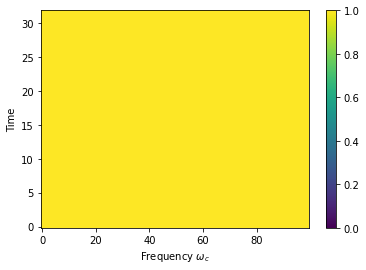

In [10]:
Y, X = np.meshgrid(simulation.timeList, [i for i in range(len(freqSweep.sweepList))])

plt.pcolormesh(X, Y, res['state fidelity'], vmin=0, vmax=1)
plt.colorbar()

plt.xlabel("Frequency $\omega_{c}$")
plt.ylabel("Time")

In [11]:
ind = 0
res['sFidStart'][ind], res['sFidEnd'][ind]

(0.999999999999907, 0.9999999999999096)